## Dependencies

 * Python 3.9 (might work with earlier versions too)
 * scipy
 * matplotlib

In [121]:
# import libraries
import math
import numpy as np
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [122]:
# function to compute correlation between two points x1, x1 according to 
# their separation
#
# if x1 and x2 are vectors of length m and n then c will be a (mxn) 
# correlation matrix.
#
# uses a SOAR correlation function with length scale L (L = 0 =>
# uncorrelated)
#
#   rho = [1 + (dx/L)]*exp(-dx/L); dx = |x1-x2|

def soar2(x1, x2, L):
    # x1 and x2 must be arrays, even if of length 1
    dim1 = len(x1)
    dim2 = len(x2)

    c = np.zeros((dim1, dim2))

    for i, xi in enumerate(x1):
        for j, xj in enumerate(x2):
            d = abs(xi - xj)
            if d == 0:
                c[i, j] = 1.0
            elif L > 0.0:
                c[i, j] = (1.0 + d/L) * math.exp(-d/L)
            else:
                c[i, j] = 0.0
    
    return c

In [123]:
# set x values at which equations are solved
x0 = 0.
xn = 10.
nx = 100 # will have nx+1 points
x = np.linspace(x0, xn, nx + 1)

In [124]:
# initialise analysis vectors
xdim = len(x)
a  = np.zeros(np.shape(x)) # analysis for 2 obs case
a1 = np.zeros(np.shape(x)) # analysis for o1 only case
a2 = np.zeros(np.shape(x)) # analysis for o2 only case

fb = 0.5 + 0.1 * np.sin(2 * math.pi * x/xn)
#print(fb)
#fb = np.zeros(np.shape(x)) # background

In [125]:
# default observation values and locations
x1 = 2.0; o1 = 1.0
x2 = 7.5; o2 = -1.0

In [126]:
# default covariances and correlation lengths
# forecast (background)
sigf = 1.0 # background error standard deviation
Lf   = 2.0 # correlation length scale
# observations
sigo = 1.0 # observation error standard deviation
Lo   = 1.0 # correlation length scale

In [127]:
# get value of background field at observation locations, Hxb

# Create a function that estimates the background at any point
# by interpolating linearly between the given background points
Hfb = interpolate.interp1d(x, fb, 'linear')

# Compute y-Hxb at each obs location
d1 = o1 - Hfb(x1)
d2 = o2 - Hfb(x2)

In [128]:
# Compute weighted correlation for each obs
cf12 = soar2([x1], [x2], Lf)[0, 0] # background
co12 = soar2([x1], [x2], Lo)[0, 0] # observations

C = sigf*sigf*cf12 + sigo*sigo*co12 # var_b*rho(x1,x2) + var_o*rho(x1,x2)

C = C/(sigf*sigf+sigo*sigo)         # [var_b*rho(x1,x2) + var_o*rho(x1,x2)]/[var_b+var_o]

W = (sigf*sigf+sigo*sigo)*(1.-C*C)

W = sigf*sigf/W 

# weight for a single ob:  var_b/(var_b+var_o)
W1 = sigf*sigf/(sigf*sigf+sigo*sigo)

In [129]:
# OI analysis

cf1 = soar2([x1], x, Lf)[0] # rho(x,x1), (xdim x 1) vector
cf2 = soar2([x2], x, Lf)[0] # rho(x,x2), (xdim x 1) vector
  
z = cf1*(d1-C*d2)+cf2*(d2-C*d1)

a  = fb + W*z        # analysis for 2 obs case
a1 = fb + cf1*W1*d1  # analysis for o1 only
a2 = fb + cf2*W1*d2  # analysis for o2 only

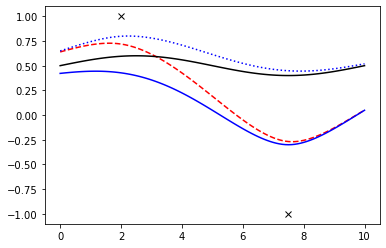

In [130]:
# Plot the data
fig = plt.figure()
plt.plot([x1, x2], [o1, o2], 'kx') # observation locations
plt.plot(x, a, 'r--')              # analysis in red dashed line
plt.plot(x, a1, 'b:')              # analysis with o1 only in blue dotted line
plt.plot(x, a2, 'b-')              # analysis with o2 only in blue dashed line
plt.plot(x, fb, 'k')               # background in black solid line
plt.show()